In [33]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
from glob import glob
import pandas as pd
import numpy as np

In [34]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Chirag
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else 'cpu'

In [36]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model = model_name,
        device = device
    )

    return theme_classifier

In [37]:
theme_classifier = load_model(device)

c:\ProgramData\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [38]:
theme_list = ["friendship", 'hope', 'sacrifice', 'battle','self development', 'betrayal', 'love', 'dialogue']

In [39]:
theme_classifier(
    "i gave him a right hook then a left jab",
    theme_list,
    multi_label=True
)

{'sequence': 'i gave him a right hook then a left jab',
 'labels': ['battle',
  'self development',
  'hope',
  'sacrifice',
  'dialogue',
  'betrayal',
  'love',
  'friendship'],
 'scores': [0.9196868538856506,
  0.5670467615127563,
  0.10998066514730453,
  0.07718312740325928,
  0.019765693694353104,
  0.012826412916183472,
  0.005526168737560511,
  0.0029951927717775106]}

In [40]:
files = glob('../data/subtitles/*.ass')

In [41]:
with open(files[0], 'r') as file:
    lines = file.readlines()
    lines = lines[27:]
    lines = [",".join(line.split(',')[9:]) for line in lines]

In [42]:
lines= [line.replace('\\N', ' ')for line in lines]

In [43]:
" ".join(lines[:10])

"A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can't let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n"

In [44]:
int(files[0].split('-')[-1].split('.')[0].strip())

1

In [45]:
def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob(dataset_path+'/*.ass')
    scripts = []
    episode_num= []
    
    for path in subtitles_paths:
        #Read lines
        with open(path, 'r') as file:
            lines = file.readlines()
            lines = lines[27:]
            lines = [",".join(line.split(',')[9:]) for line in lines]
        lines= [line.replace('\\N', ' ')for line in lines]
        script = " ".join(lines)

        episdoe = int(path.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episdoe)
    
    df = pd.DataFrame.from_dict({"episode":episode_num, "Scripts": scripts})
    return df

In [46]:
dataset_path = '../data/subtitles'
df = load_subtitles_dataset(dataset_path)

In [47]:
df.head()

,episode,Scripts
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


In [48]:
script = df.iloc[0]['Scripts']

In [49]:
script_sentence = sent_tokenize(script)
script_sentence[:3]

['A long time ago, a powerful demon fox appeared with nine tails.',
 'With its powerful tails,\n it could smash mountains and create tidal waves.',
 'A band of Ninjas rose to defend their village from attack.']

In [50]:
#Batch sentence
sentence_batch_size = 20
script_batches = []
for index in range(0, len(script_sentence), sentence_batch_size):
    sent = " ".join(script_sentence[index: index+sentence_batch_size])
    script_batches.append(sent)

In [51]:
theme_output = theme_classifier(
    script_batches[:2], 
    theme_list,
    multi_label = True

)

In [52]:
theme_output

[{'sequence': "A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
  'labels': ['dialogue',
   'betrayal',
   'battle',
   'sacrifice',
   'self development',
   'hope',
   'friendship',
   'love'],
  'scores': [0.980073869228363,
   0.9396896362304688,
   0.8546874523162842,
   0.7349812388420105,
   0.7284945249557495,
   0.1990976482629776

In [53]:
#WRANGE OUTPUT
#battle [0.514]
themes = {}
for output in theme_output:
    for label, score in zip(output['labels'], output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [54]:
def get_themes_inference(script):

    script_sentence = sent_tokenize(script)
    #Batch sentence
    sentence_batch_size = 20
    script_batches = []
    for index in range(0, len(script_sentence), sentence_batch_size):
        sent = " ".join(script_sentence[index: index+sentence_batch_size])
        script_batches.append(sent)

    theme_output = theme_classifier(
        script_batches[:2], 
        theme_list,
        multi_label = True
    )
        
    #WRANGE OUTPUT
#battle [0.514]
    themes = {}
    for output in theme_output:
        for label, score in zip(output['labels'], output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)
    themes = {key: np.mean(np.array(value)) for key, value in themes.items()}
    return themes

In [55]:
df = df.head(2)

In [56]:
output_themes = df['Scripts'].apply(get_themes_inference)


In [57]:
theme_df = pd.DataFrame(output_themes.tolist())

In [58]:
df[theme_df.columns] = theme_df
df

,episode,Scripts,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.958543,0.792706,0.756408,0.680432,0.798157,0.201669,0.072628,0.034141
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.960605,0.429943,0.684844,0.570702,0.482807,0.154534,0.046260,0.173260


In [60]:
df = df.drop('dialogue', axis=1)

In [65]:
theme_output = df.drop(['episode', 'Scripts'], axis=1).sum().reset_index()
theme_output.columns = ['theme', 'score']

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns


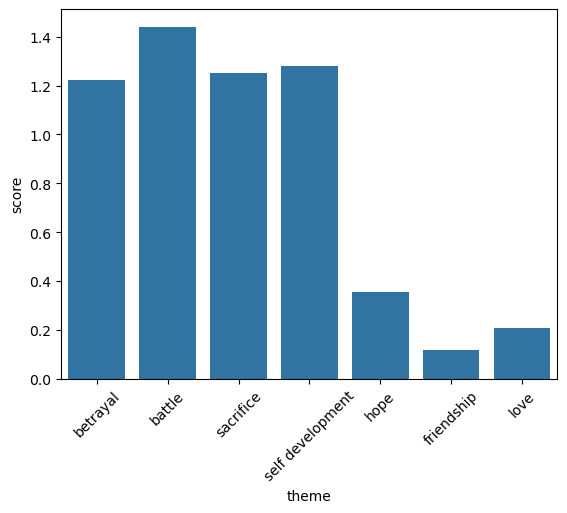

In [69]:
sns.barplot(data=theme_output, x="theme", y="score")
plt.xticks(rotation=45)
plt.show()